# Background

In this notebook we want to test the intermittent-correlations model.

In [1]:
import os, sys
%pylab inline
plt.style.use('default')


Populating the interactive namespace from numpy and matplotlib


In [8]:
from importlib import reload
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import namedtuple

In [3]:
from scipy.stats import norm, gamma

In [4]:
import em; reload(em)

<module 'em' from '/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/em.py'>

# Exponential data

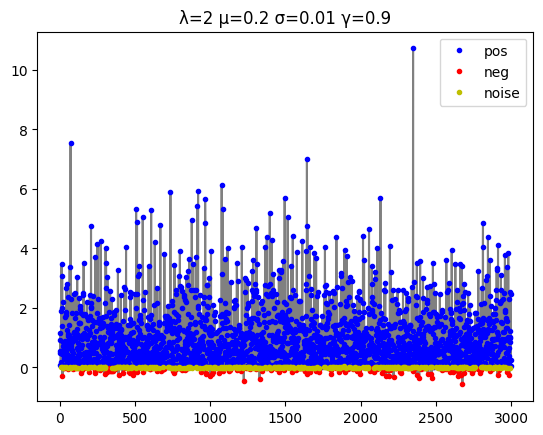

In [87]:
reload(em)
random.seed(0)
M = 3000
λ = 2.
μ = 0.2
σ = 0.01
γ = 0.9
p = ExpParams(λ, μ, σ, γ)
y,labs = gen_data(M, p)
plot_data(p, y, labs)


Iter    0: n+=2289, n-= 111 λ=   2.2, μ=  0.19, σ= 0.022, γ=   0.8
Iter    1: n+=2342, n-= 127 λ=   2.1, μ=  0.19, σ= 0.015, γ=  0.82
Iter    2: n+=2368, n-= 142 λ=   2.1, μ=  0.19, σ= 0.012, γ=  0.84
Iter    3: n+=2387, n-= 156 λ=   2.1, μ=  0.18, σ=  0.01, γ=  0.85
Iter    4: n+=2393, n-= 160 λ=   2.1, μ=  0.18, σ=0.0096, γ=  0.85
Iter    5: n+=2397, n-= 160 λ=   2.1, μ=  0.18, σ=0.0095, γ=  0.85
Iter    6: n+=2400, n-= 162 λ=   2.1, μ=  0.18, σ=0.0093, γ=  0.85
Iter    7: n+=2401, n-= 165 λ=     2, μ=  0.18, σ=0.0091, γ=  0.86
Iter    8: n+=2402, n-= 168 λ=     2, μ=  0.18, σ= 0.009, γ=  0.86
Iter    9: n+=2402, n-= 168 λ=     2, μ=  0.18, σ= 0.009, γ=  0.86
Converged.
λ=2, μ=0.18, σ=0.009, γ=0.86


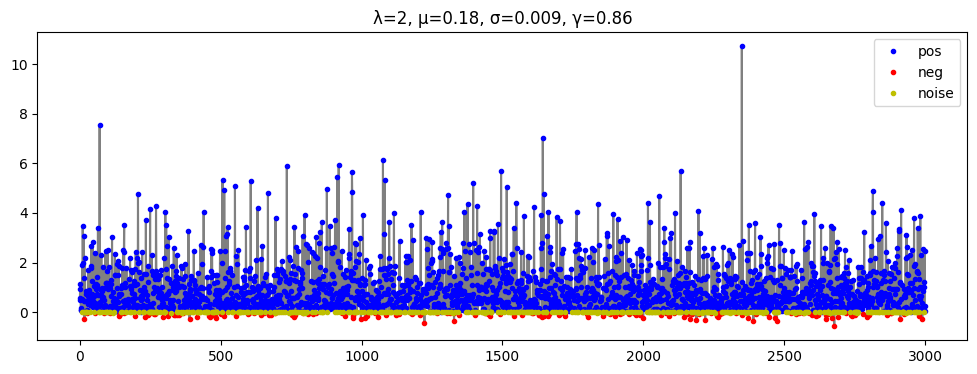

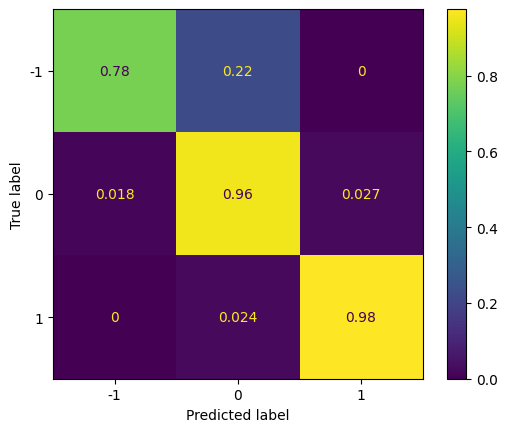

In [118]:
reload(em)
ret = em.run_em(y, β = 1e5, γ_init = 0.8, max_iter = 50, tol = 1e-8)
print_params(*ret[:4])
plot_data(*ret[:4], y, *ret[4:], figsize=(12,4))
plot_confusion_matrix(labs, ret[4])

Iter    0: n+=2289, n-= 111 λ=   2.2, μ=  0.19, σp= 0.023, σn= 0.018, γ=   0.8
Iter    1: n+=2336, n-= 135 λ=   2.1, μ=  0.19, σp= 0.016, σn= 0.013, γ=  0.82
Iter    2: n+=2361, n-= 152 λ=   2.1, μ=  0.19, σp= 0.013, σn= 0.011, γ=  0.84
Iter    3: n+=2384, n-= 160 λ=   2.1, μ=  0.19, σp=  0.01, σn=0.0097, γ=  0.85
Iter    4: n+=2393, n-= 162 λ=   2.1, μ=  0.18, σp=0.0093, σn=0.0096, γ=  0.85
Iter    5: n+=2401, n-= 165 λ=     2, μ=  0.18, σp=0.0087, σn=0.0094, γ=  0.86
Iter    6: n+=2403, n-= 168 λ=     2, μ=  0.18, σp=0.0086, σn=0.0091, γ=  0.86
Iter    7: n+=2408, n-= 171 λ=     2, μ=  0.18, σp=0.0083, σn=0.0089, γ=  0.86
Iter    8: n+=2413, n-= 172 λ=     2, μ=  0.18, σp=0.0079, σn=0.0089, γ=  0.86
Iter    9: n+=2416, n-= 175 λ=     2, μ=  0.18, σp=0.0077, σn=0.0087, γ=  0.86
Iter   10: n+=2418, n-= 178 λ=     2, μ=  0.18, σp=0.0075, σn=0.0085, γ=  0.87
Iter   11: n+=2419, n-= 179 λ=     2, μ=  0.18, σp=0.0075, σn=0.0084, γ=  0.87
Iter   12: n+=2419, n-= 181 λ=     2, μ=  0.18, σp=0

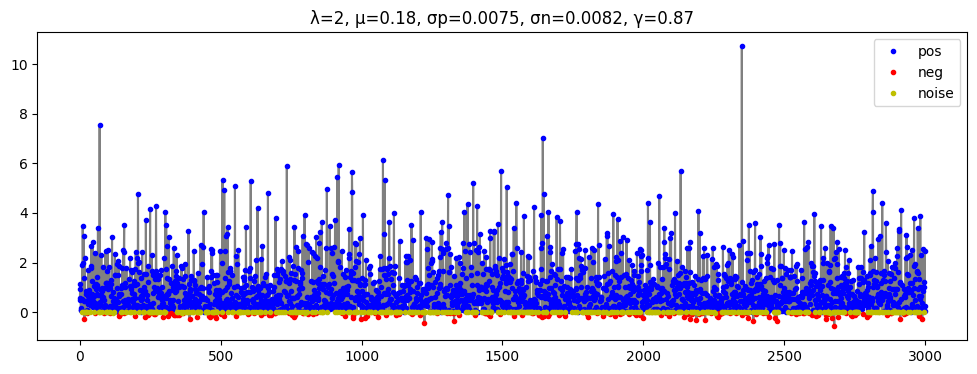

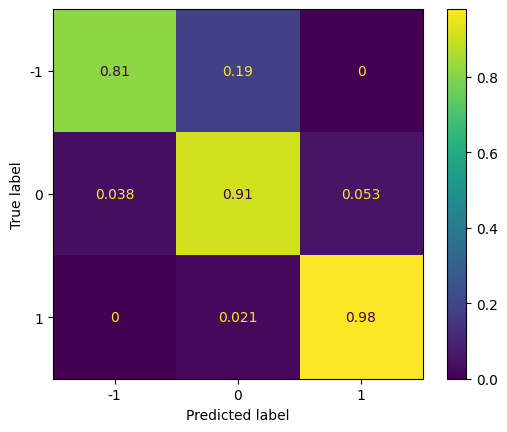

In [119]:
reload(em)
ret = em.run_em2(y, β = 1e5, γ_init = 0.8, max_iter = 50, tol = 1e-8)
print_params2(*ret[:5])
plot_data2(*ret[:5], y, *ret[5:], figsize=(12,4))
plot_confusion_matrix(labs, ret[5])


# Let's try on the real data

In [207]:
# Load the data
os.environ["FISHER_PLUMES"] = os.path.join(os.environ["GIT"],"fisher-plumes")
os.chdir(os.environ["FISHER_PLUMES"])
import units; reload(units); UNITS = units.UNITS;

In [208]:
import boulder;   reload(boulder)
import crick;     reload(crick)
import surrogate; reload(surrogate)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
import utils; reload(utils); from utils import dict_update, dict_update_from_field
import proc; reload(proc);
FisherPlumes = fp.FisherPlumes
crick.logger.setLevel(logging.DEBUG)
fp.logger.setLevel(logging.INFO)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:crimgrid_w1                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w2                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w3                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w4                                     : y0 - y9 (16 datasets)


INFO:crick:n12T                                            : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12Tslow                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12dishT                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n16T                                            : Y0.440 - Y0.560 (16 datasets)


INFO:crick:n16Tslow                                        : Y0.440 - Y0.560 (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:crimgrid_w1                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w2                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w3                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w4                                     : y0 - y9 (16 datasets)


INFO:crick:n12T                                            : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12Tslow                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12dishT                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n16T                                            : Y0.440 - Y0.560 (16 datasets)


INFO:crick:n16Tslow                                        : Y0.440 - Y0.560 (16 datasets)


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


In [209]:
window_length = 1 * UNITS.second
windows       = ['boxcar', 'hann', ('kaiser',9), ('kaiser', 16)]
window_shape  = windows[1]
fit_k         = False
fit_b         = True


In [210]:
to_use = {"16Ts":{"sim_name":"n16Tslow"},
          "bw":  {"sim_name":"boulder16"},
          "s=w": {"sim_name":"surr_all_equal", "surrogate_k": 0},
          "s=p": {"sim_name":"surr_all_equal", "surrogate_k": 4},
          "shw": {"sim_name":"surr_high",      "surrogate_k": 0},          
          "shp": {"sim_name":"surr_high",      "surrogate_k": 4},
          "s=w_q0":{"sim_name":"surr_quad",      "surrogate_k": 0, "phi":0},
          "s=w_q1":{"sim_name":"surr_quad",      "surrogate_k": 0, "phi":pi/3},
}


In [211]:
safe_load = lambda d: d[0] if d is not None else d
[f.logger.setLevel(logging.WARN) for f in [crick, boulder,fp]];
loaded = {k:safe_load(proc.load_data(init_filter = v,
                                       compute_filter = {
                                           "window_shape":window_shape,
                                           "window_length":window_length,
                                           "fit_k":fit_k,
                                           "fit_b":fit_b,
                                       }))
          for k,v in to_use.items()}

data =  {k:FisherPlumes(d) for k,d in loaded.items() if d is not None}

for k, l in loaded.items():
    if l is None:
        print(f"WARNING: No data for {k=}")

[f.logger.setLevel(logging.INFO) for f in [crick, boulder,fp]];


                    proc 2023/09/04 16:31:10     INFO: Loading init_filter={'sim_name': 'n16Tslow'} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/n16Ts.1/78281891d4d0a86d.p


                    proc 2023/09/04 16:31:17     INFO: Returning 1 results.


                    proc 2023/09/04 16:31:17     INFO: Loading init_filter={'sim_name': 'boulder16'} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/bw.1/a870f77347a4942f.p


                    proc 2023/09/04 16:31:18     INFO: Returning 1 results.


                    proc 2023/09/04 16:31:18     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=w.1/d939203ae60ec26a.p


                    proc 2023/09/04 16:31:20     INFO: Returning 1 results.


                    proc 2023/09/04 16:31:20     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.1/ea1b3a6e626f84a2.p


                    proc 2023/09/04 16:31:20     INFO: Returning 1 results.


                    proc 2023/09/04 16:31:20     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 0} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/shw.1/c608e21b188eccdc.p


                    proc 2023/09/04 16:31:22     INFO: Returning 1 results.


                    proc 2023/09/04 16:31:22     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 4} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/shp.1/9aa0c12903638012.p


                    proc 2023/09/04 16:31:23     INFO: Returning 1 results.


                    proc 2023/09/04 16:31:23     INFO: Loading init_filter={'sim_name': 'surr_quad', 'surrogate_k': 0, 'phi': 0} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=w_q.1/590d29b026eb2834.p


                    proc 2023/09/04 16:31:24     INFO: Returning 1 results.


                    proc 2023/09/04 16:31:24     INFO: Loading init_filter={'sim_name': 'surr_quad', 'surrogate_k': 0, 'phi': 1.0471975511965976} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=w_q.2/7213b58bc65c326d.p


                    proc 2023/09/04 16:31:25     INFO: Returning 1 results.


INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coor

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coor

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-59.10548154],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-59.10548154],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-19.89229135],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-12.44132889],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 18.49143025],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-63.2686171 ],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-60.09607302],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-56.14996259],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-25.55298284],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-32.55458394],
       [ 

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-11.57091867],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-12.9775294 ],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-41.73591707],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-57.06706625],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-19.65668695],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-21.26115061],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 14.80550149],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-7.09763417],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-7.09763417],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-7.9967684 ],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-14.36303866],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-12.56674671],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-16.27835016],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-16.34731828],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-14.11810432],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -7.15038746],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -9.94393516],
       [-

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-5.9693652 ],
       [

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-0.80587148],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-1.09364524],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-2.18398555],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-4.95836736],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 0.4910835 ],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-5.241228  ],
       

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-59.105481

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-59.105481

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -5.849007

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -4.574717

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 33.909967

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-75.398814

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-44.311011

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-41.766802

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[19.70954707]

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -8.25426173],

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[   7.4133005

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[  8.7539695

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-53.6985321

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-77.0756848

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-26.8604322

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-23.2495403

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 14.9550891

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': arr

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': arr

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

In [212]:
iprb = 0

In [218]:
F = data["16Ts"]
dd= array(list(F.pairs_um.keys()))

In [219]:
dd[dd>=0]

array([     0,   8000,  16000,  24000,  32000,  40000,  48000,  56000,
        64000,  72000,  80000,  88000,  96000, 104000, 112000, 120000])

In [220]:
d = 16000
f = 5
y  = F.rho[iprb][d][0][f]
la = F.la[iprb][d][0,f,0]
mu = F.mu[iprb][d][0,f,0]
print(la, mu, std(y))
la_ = la/std(y)
mu_ = mu/std(y)
y_  =  y/std(y)
print(la_, mu_)

0.01972166011110816 0.002959265558152036 0.019179651100318492
1.0282595865771857 0.15429193902817634


Iter    0: n+= 385, n-=   4 λ=   6.2, μ=  0.48, σ=  0.38, γ=   0.3
Iter    1: n+= 632, n-=   1 λ=   4.6, μ=  0.19, σ=  0.24, γ=  0.33
Iter    2: n+= 855, n-=   4 λ=   3.8, μ=  0.25, σ=  0.17, γ=  0.36
Iter    3: n+= 999, n-=  20 λ=   3.5, μ=  0.43, σ=  0.12, γ=  0.38
Iter    4: n+=1152, n-=  45 λ=   3.1, μ=  0.46, σ= 0.086, γ=   0.4
Iter    5: n+=1300, n-=  61 λ=   2.8, μ=  0.44, σ= 0.066, γ=  0.42
Iter    6: n+=1436, n-=  85 λ=   2.6, μ=  0.42, σ= 0.049, γ=  0.45
Iter    7: n+=1547, n-= 115 λ=   2.4, μ=  0.41, σ= 0.038, γ=  0.46
Iter    8: n+=1654, n-= 136 λ=   2.3, μ=  0.39, σ= 0.029, γ=  0.48
Iter    9: n+=1729, n-= 150 λ=   2.2, μ=  0.38, σ= 0.024, γ=  0.49
Iter   10: n+=1804, n-= 162 λ=   2.1, μ=  0.36, σ=  0.02, γ=   0.5
Iter   11: n+=1872, n-= 175 λ=     2, μ=  0.35, σ= 0.017, γ=  0.51
Iter   12: n+=1930, n-= 184 λ=   1.9, μ=  0.34, σ= 0.014, γ=  0.52
Iter   13: n+=1999, n-= 195 λ=   1.9, μ=  0.33, σ= 0.011, γ=  0.53
Iter   14: n+=2058, n-= 206 λ=   1.8, μ=  0.32, σ=0.0095, γ=  

(0.0, 200.0)

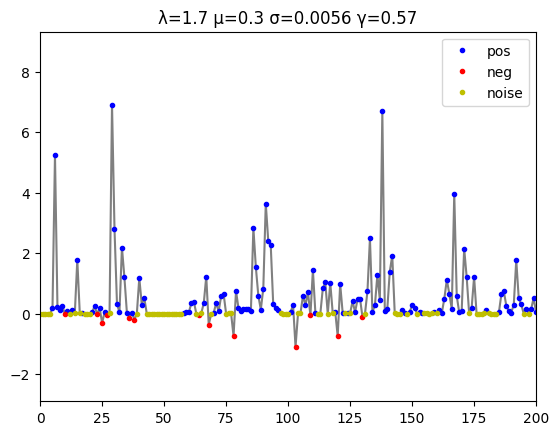

In [228]:
reload(em)
#ret = em.run_em2(y_, β = 1e6,  γ_init = 0.1, max_iter = 50, tol = 1e-6)
ret = em.run_em(y_, β = 1e-8,  γ_init = 0.1, max_iter = 50, tol = 1e-6, beta_mean = 0.5, beta_strength=1)
print(f"# noise: {sum(ret[-1]==0)}")
print(f"# pos:   {sum(ret[-1]>0)}")
print(f"# neg:   {sum(ret[-1]<0)}")
plot_data(ret[0], y_, ret[-1])
xlim(0,200)

In [ ]:
res = em.run_em(y

In [235]:
params_init = em.GammaParams(ret[0].λ, ret[0].μ, ret[0].σ, ret[0].γ, 1, 1)
ret1 = em.run_gamma_em(y_, params_init, β = 1e1, max_iter = 50, tol = 1e-8, beta_mean = 0.8, beta_strength=1.)


Iter    0: n+=2225, n-= 243 n0=1424 λ=1.3        μ=0.21       σ=0.0057     γ=0.72       k=0.61       m=1         
Iter    1: n+=2410, n-= 244 n0=1238 λ=1.6        μ=0.23       σ=0.0047     γ=0.74       k=0.45       m=0.95      
Iter    2: n+=2730, n-= 259 n0= 903 λ=1.9        μ=0.24       σ=0.004      γ=0.78       k=0.33       m=0.86      
Iter    3: n+=3016, n-= 273 n0= 603 λ=2          μ=0.24       σ=0.0036     γ=0.82       k=0.3        m=0.83      
Iter    4: n+=3202, n-= 281 n0= 409 λ=2          μ=0.24       σ=0.0033     γ=0.85       k=0.28       m=0.82      
Iter    5: n+=3377, n-= 288 n0= 227 λ=1.9        μ=0.23       σ=0.0032     γ=0.87       k=0.27       m=0.81      
Iter    6: n+=3377, n-= 293 n0= 222 λ=1.9        μ=0.23       σ=0.0029     γ=0.87       k=0.27       m=0.8       
Iter    7: n+=3377, n-= 296 n0= 219 λ=1.9        μ=0.23       σ=0.0028     γ=0.87       k=0.27       m=0.79      
Iter    8: n+=3377, n-= 298 n0= 217 λ=1.9        μ=0.23       σ=0.0027     γ=0.87       

In [241]:
cdf_fun0 = lambda x: fpt.alaplace_cdf(la_, mu_, x)
#cdf_fun1 = lambda x: cdf2(*ret[:5], x)
cdf_fun1 = lambda x: em.cdf_exp(ret[0], x)
cdf_fun2 = lambda x: em.cdf_gamma(ret1[0],x)

In [245]:
reload(fpt)

<module 'fisher_plumes_tools' from '/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py'>

0.40979882230632864 3.962513730340064 4.372312552646393
0.40979882230632864 3.962513730340064 4.372312552646393


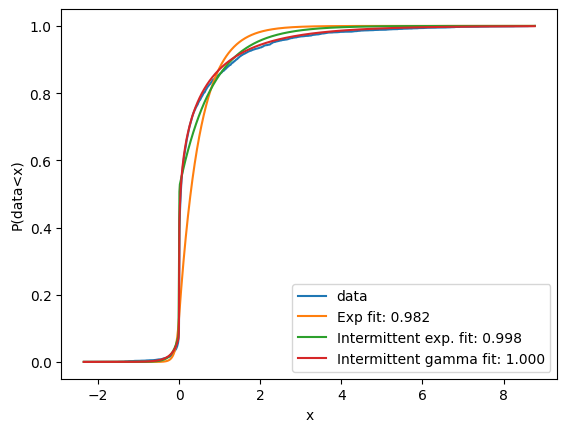

In [248]:
cdf_true, xv = em.cdf_data(y_)
plot(xv, cdf_true, "-",label="data" )

old_r2 = fpt.compute_r2_value(cdf_fun0, y_, n = 1001)
cdf0   = cdf_fun0(xv)
plot(xv, cdf0, "-", label=f"Exp fit: {old_r2:.3f}")

new_r2 = fpt.compute_r2_value(cdf_fun1, y_, n = 1001)
cdf1   = cdf_fun1(xv)
plot(xv, cdf1, "-", label=f"Intermittent exp. fit: {new_r2:.3f}")

gam_r2 = fpt.compute_r2_value(cdf_fun2, y_, n = 1001)
cdf2   = cdf_fun2(xv)
plot(xv, cdf2, "-", label=f"Intermittent gamma fit: {gam_r2:.3f}")
xlabel("x")
ylabel("P(data<x)")
legend()

# Run Gamma em

In [472]:
reload(em)
λ_init, μ_init, σ_init, γ_init = ret[:4]
ret1 = em.run_gamma_em(y_, λ_init/2, μ_init/2, σ_init**2, γ_init,
                       β = 1e-8, max_iter = 50, tol = 1e-6, beta_mean = 0.5, beta_strength=1, ga_max = 1/2)

Iter    0: n+=2243, n-= 246 λ=  0.83, μ=  0.15, σ=0.0056, γ=  0.57 k0=   0.5 k1=   0.5
Iter    1: n+=2442, n-= 319 λ=   1.4, μ=  0.14, σ= 0.005, γ=   0.6 k0=   0.5 k1=   0.5
Iter    2: n+=2439, n-= 319 λ=   1.6, μ=  0.16, σ=0.0035, γ=   0.6 k0=   0.5 k1=   0.5
Iter    3: n+=2465, n-= 320 λ=   1.6, μ=  0.16, σ=0.0035, γ=  0.61 k0=   0.5 k1=   0.5
Iter    4: n+=2467, n-= 320 λ=   1.7, μ=  0.17, σ=0.0035, γ=  0.61 k0=   0.5 k1=   0.5
Iter    5: n+=2467, n-= 319 λ=   1.7, μ=  0.17, σ=0.0035, γ=  0.61 k0=   0.5 k1=   0.5
Iter    6: n+=2466, n-= 319 λ=   1.7, μ=  0.17, σ=0.0035, γ=  0.61 k0=   0.5 k1=   0.5
Iter    7: n+=2466, n-= 319 λ=   1.7, μ=  0.17, σ=0.0035, γ=  0.61 k0=   0.5 k1=   0.5
Iter    8: n+=2466, n-= 319 λ=   1.7, μ=  0.17, σ=0.0035, γ=  0.61 k0=   0.5 k1=   0.5
Iter    9: n+=2466, n-= 319 λ=   1.7, μ=  0.17, σ=0.0035, γ=  0.61 k0=   0.5 k1=   0.5
Iter   10: n+=2466, n-= 319 λ=   1.7, μ=  0.17, σ=0.0035, γ=  0.61 k0=   0.5 k1=   0.5
Iter   11: n+=2466, n-= 319 λ=   1.7, μ=  0

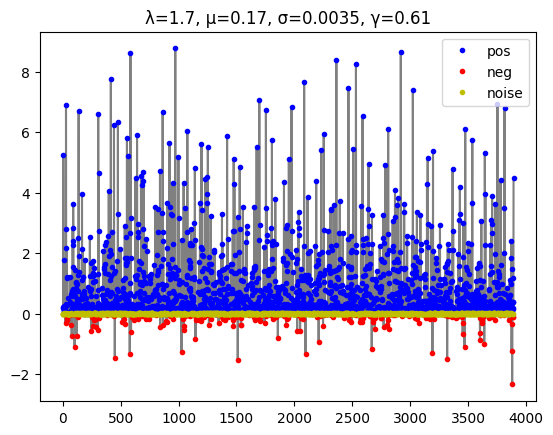

In [473]:
plot_data(*ret1[:4], y_, ret1[-1])

In [440]:
cdf_gamma(*ret1[:6], y_)

array([0.12806243, 0.12636711, 0.12668196, ..., 0.02463897, 0.57127678,
       0.8063287 ])

In [429]:
ret1

(0.3057040179908431,
 0.1628908303605703,
 0.08154557502398506,
 0.408016443987667,
 4.999995663094733,
 4.9999963716546345,
 array([0, 0, 0, ..., 0, 1, 1]))

In [413]:
from scipy.special import digamma, gamma

In [405]:
λ_old=1.6620214540887672/2
μ_old=0.1480534451445213
yps_n=0.7112273572498953
f    = lambda k: (λ_old ** k) * gamma(k) * (log(λ_old) + digamma(k))/(gamma(1) * μ_old**1 + gamma(k) * λ_old**k) - yps_n

In [406]:
from scipy.optimize import root_scalar

In [408]:
root_scalar(f, bracket=[1e-6, 5], x0 = 1.)

      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 3.14489584222965

In [395]:
f(2)

0.17223986818800663

In [ ]:
gk1  = 1.
dgk1 = -0.5772156649015329
Z = 1.9581283443778097
yps=1755.3091176927414
n = 2468

        f    = lambda x: x**(k1) * gk1*(log(x) + dgk1)/Z - yps/n


# Fit the heavy tails

In [290]:
from scipy.stats import fisk, lognorm, expon, pareto, cauchy, 

In [282]:
mean(ys[ys>0])

0.520963360388306

In [304]:
Ds = [v for k,v in scipy.stats.__dict__.items() if hasattr(v, "fit")]

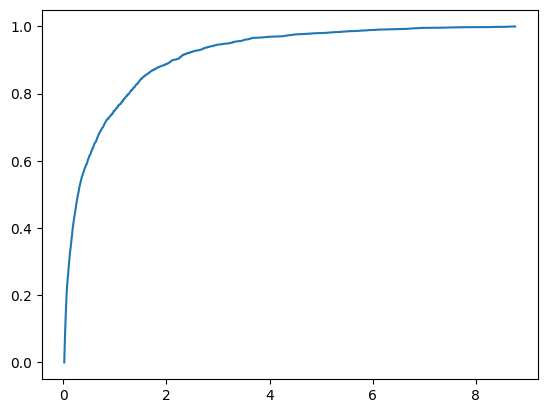

                   ksone: 0.623
               kstwobign: 0.234
                    norm: 0.261


                   alpha: 0.103
                  anglit: 0.503


                 arcsine: 0.578


                    beta: 0.164


               betaprime: 0.068


                bradford: 0.559


                    burr: 0.059
                  burr12: 0.041


                    fisk: 0.042
                  cauchy: 0.285
                     chi: 0.106


                    chi2: 0.064
                  cosine: 0.365
                  dgamma: 0.395
                dweibull: 0.400
                   expon: 0.210


               exponnorm: 0.210


               exponweib: 0.031
                exponpow: 0.252
             fatiguelife: 0.042


              foldcauchy: 0.100
                       f: 0.033
                foldnorm: 0.363


             weibull_min: 0.038
        truncweibull_min: 0.128


             weibull_max: 0.188
             genlogistic: 0.188
               genpareto: 0.064


                genexpon: 0.211
              genextreme: 0.068


                   gamma: 0.071
                  erlang: 0.068


                gengamma: 0.040
         genhalflogistic: 0.286


                gompertz: 0.177
                gumbel_r: 0.188
                gumbel_l: 0.379
              halfcauchy: 0.100
            halflogistic: 0.287
                halfnorm: 0.363
               hypsecant: 0.276


              gausshyper: 0.094
                invgamma: 0.080
                invgauss: 0.083


             geninvgauss: 0.016


            norminvgauss: 0.083
              invweibull: 0.068
               johnsonsb: 0.028


               johnsonsu: 0.050
                 laplace: 0.338
      laplace_asymmetric: 0.210
                    levy: 0.098
                  levy_l: 0.637
                logistic: 0.261
                loggamma: 0.266
              loglaplace: 0.058


                 lognorm: 0.049
                  gibrat: 0.114
                 gilbrat: 0.114
                 maxwell: 0.235
                  mielke: 0.051


<ipython-input-310-3b1b9e0bb6c2>:10: DeprecationWarning:         `gilbrat.fit` is deprecated, use `gibrat.fit` instead!
        `gilbrat` is a misspelling of the correct name for the `gibrat` distribution, and will be removed in SciPy 1.11.
  params = D.fit(yp)
<ipython-input-310-3b1b9e0bb6c2>:11: DeprecationWarning:         `gilbrat.cdf` is deprecated, use `gibrat.cdf` instead!
        `gilbrat` is a misspelling of the correct name for the `gibrat` distribution, and will be removed in SciPy 1.11.
  yf = D.cdf(xx, *params)


                  kappa4: 0.266
                  kappa3: 0.050
                   moyal: 0.180
                nakagami: 0.113


                    ncx2: 0.106


                     ncf: 0.039
                       t: 0.294


                     nct: 0.084
                  pareto: 0.064
                   lomax: 0.062


                pearson3: 0.058
                powerlaw: 0.247


            powerlognorm: 0.036


               powernorm: 1.000
                   rdist: 0.261
                rayleigh: 0.256
              loguniform: 0.157


              reciprocal: 0.157
                    rice: 0.256


           recipinvgauss: 0.072
            semicircular: 0.547
              skewcauchy: 0.100


                skewnorm: 0.363
               trapezoid: 0.821
                   trapz: 0.821
                  triang: 0.434
              truncexpon: 0.480


               truncnorm: 0.361


             tukeylambda: 0.298
                 uniform: 0.675


           vonmises_line: 0.260
                    wald: 0.129
              wrapcauchy: 0.475
                 gennorm: 0.362
             halfgennorm: 0.033


             crystalball: 0.261
                   argus: 0.505


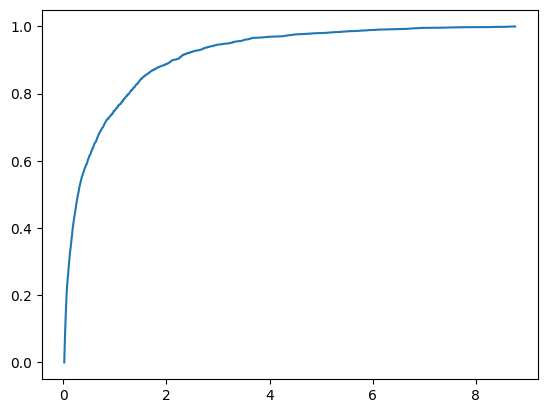

In [310]:
#Ds = [fisk, lognorm, expon, cauchy, scipy.stats.t]
#yp = ys[ys>0]
yp = y_[ret[-1]==1]
xx = sorted(yp)
yy = arange(len(xx))/len(xx)
fits = {}
for D in Ds:
    try:
        params = D.fit(yp)
        yf = D.cdf(xx, *params)
    except:
        continue
    if max(yf)>1:
        continue
    fits[D.name] = (params, yf, max(abs(yf-yy)))
    print(f"{D.name:>24s}: {fits[D.name][-1]:.3f}")

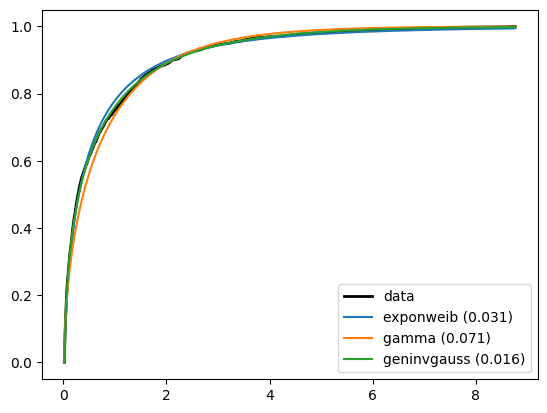

In [350]:
plot(xx, yy, "k", linewidth=2, label='data')
for k, v in fits.items():
    if v[2]>10.02 or k in ["gamma",  "geninvgauss", "exponweib"]:
        plot(xx, v[1], label=f"{k} ({v[2]:.3f})")
legend()    

In [349]:
fits["gamma"][0]

(0.5205063367935592, 0.015815139275951375, 1.5004107066965233)

In [348]:
[print(f"{n:>24s}: {v[2]:.4f}") for n,v in sorted(fits.items(), key=lambda x: x[1][2])];

             geninvgauss: 0.0158
               johnsonsb: 0.0284
               exponweib: 0.0310
                       f: 0.0325
             halfgennorm: 0.0329
            powerlognorm: 0.0358
             weibull_min: 0.0378
                     ncf: 0.0395
                gengamma: 0.0399
                  burr12: 0.0414
                    fisk: 0.0415
             fatiguelife: 0.0420
                 lognorm: 0.0491
               johnsonsu: 0.0499
                  kappa3: 0.0501
                  mielke: 0.0505
              loglaplace: 0.0577
                pearson3: 0.0579
                    burr: 0.0586
                   lomax: 0.0615
               genpareto: 0.0640
                  pareto: 0.0640
                    chi2: 0.0642
                  erlang: 0.0676
              invweibull: 0.0680
              genextreme: 0.0680
               betaprime: 0.0682
                   gamma: 0.0707
           recipinvgauss: 0.0724
                invgamma: 0.0796
          

In [333]:
fits["geninvgauss"][0]

(0.26573083490644556,
 0.09201908971753858,
 0.014200386285752153,
 0.0982384069905814)

In [334]:
?scipy.stats.geninvgauss

In [311]:
fits.keys()

dict_keys(['ksone', 'kstwobign', 'norm', 'alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'burr12', 'fisk', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'expon', 'exponnorm', 'exponweib', 'exponpow', 'fatiguelife', 'foldcauchy', 'f', 'foldnorm', 'weibull_min', 'truncweibull_min', 'weibull_max', 'genlogistic', 'genpareto', 'genexpon', 'genextreme', 'gamma', 'erlang', 'gengamma', 'genhalflogistic', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'gausshyper', 'invgamma', 'invgauss', 'geninvgauss', 'norminvgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'laplace', 'laplace_asymmetric', 'levy', 'levy_l', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'gibrat', 'gilbrat', 'maxwell', 'mielke', 'kappa4', 'kappa3', 'moyal', 'nakagami', 'ncx2', 'ncf', 't', 'nct', 'pareto', 'lomax', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'rayleigh', 'loguniform', 'reciprocal', 'rice', 'recipinvgauss', 'semicircu

# Gamma data

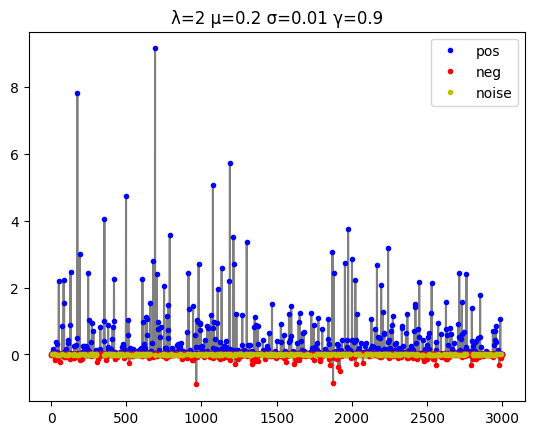

In [105]:
reload(em)
random.seed(0)
M = 3000
λ = 2.
μ = 0.2
σ = 0.01
γ = 0.9
k = 0.1
m = 0.1
p0 = em.GammaParams(λ, μ, σ, γ, k, m)
y,labs = em.gen_gamma_data(M, p0)
em.plot_data(p, y, labs)

In [119]:
from scipy.special import gamma as gamma_fun

In [203]:
reload(em)
params_init = em.GammaParams(λ, μ, σ, γ, k, m)
res = em.run_gamma_em(y, params_init, β = 1e1, max_iter = 50, tol = 1e-8, beta_mean = 0.8, beta_strength=1.)

Iter    0: n+= 493, n-= 199 n0=2308 λ=0.73       μ=0.16       σ=0.0054     γ=0.52       k=0.7        m=0.71      
Iter    1: n+= 902, n-= 541 n0=1557 λ=4.2        μ=0.4        σ=0.0043     γ=0.64       k=0.077      m=0.086     
Iter    2: n+=1310, n-= 972 n0= 718 λ=2.4        μ=0.23       σ=0.0048     γ=0.78       k=0.088      m=0.092     
Iter    3: n+=1410, n-=1079 n0= 511 λ=2.1        μ=0.21       σ=0.005      γ=0.81       k=0.092      m=0.097     
Iter    4: n+=1464, n-=1111 n0= 425 λ=2          μ=0.2        σ=0.0052     γ=0.83       k=0.094      m=0.099     
Iter    5: n+=1491, n-=1128 n0= 381 λ=1.9        μ=0.19       σ=0.0052     γ=0.84       k=0.095      m=0.1       
Iter    6: n+=1508, n-=1140 n0= 352 λ=1.9        μ=0.19       σ=0.0053     γ=0.84       k=0.096      m=0.1       
Iter    7: n+=1513, n-=1149 n0= 338 λ=1.9        μ=0.19       σ=0.0053     γ=0.84       k=0.096      m=0.1       
Iter    8: n+=1516, n-=1153 n0= 331 λ=1.8        μ=0.19       σ=0.0053     γ=0.84       

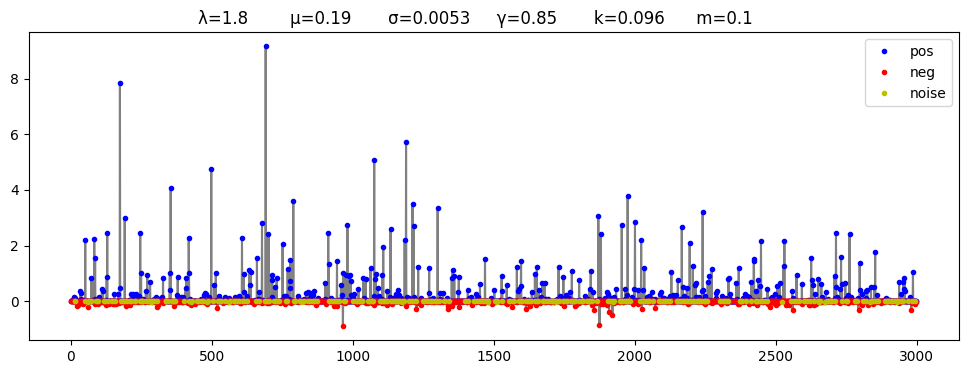

In [204]:
em.plot_data(res[0], y, res[-1], figsize=(12,4))

8.099228907085527 10.19632508706787 18.295553994153394
GammaParams(λ=1.8368720932762093, μ=0.18714717066585432, σ=0.005272797866651912, γ=0.8456666666666667, k=0.09640871690303357, m=0.1013143414670196)
7.919360775299331 10.479699282665333 18.399060057964665


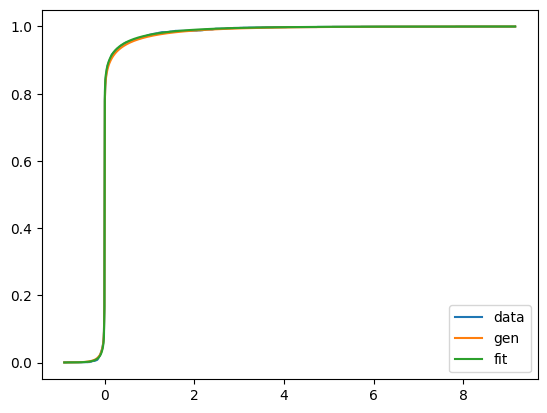

In [205]:
# Let's plot the data cdf
reload(em)
cc, xx = em.cdf_data(y)
c0 = em.cdf_gamma(p0, xx)
p1 = res[0]
print(res[0])
c1 = em.cdf_gamma(p1, xx)
plot(xx,cc, label="data")
plot(xx,c0, label="gen")
plot(xx,c1, label="fit")
legend()

In [206]:
p0

GammaParams(λ=2.0, μ=0.2, σ=0.01, γ=0.9, k=0.1, m=0.1)

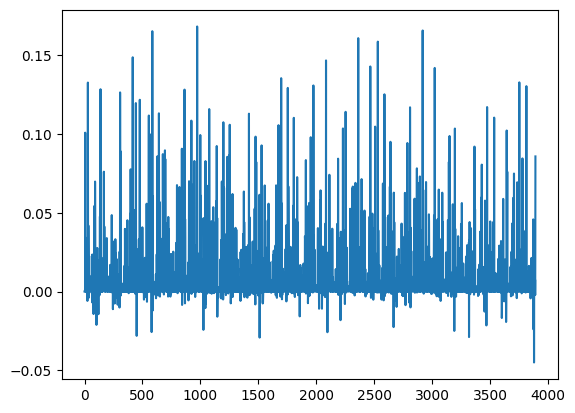

In [217]:
plot(y)